# Looking into mode fitting with pystan
## Simple test of a single mode

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
plt.rcParams['figure.figsize'] = [12,10]

Let's make some simulated data.  We will need a frequency range.  We then create the model of a symmetric Lorentzian in addition to a background.  The limit model is then multiplied by chi squared 2 degrees of freedom noise.

$M(f; \nu, w, h, b, e) = \left( b + \frac{1}{2\pi}\frac{hw}{(\nu - f)^2 + \frac{w^2}{4}} \right) e$

where 

$e \sim \chi^{2}_{2}$.

Text(0,0.5,'Power')

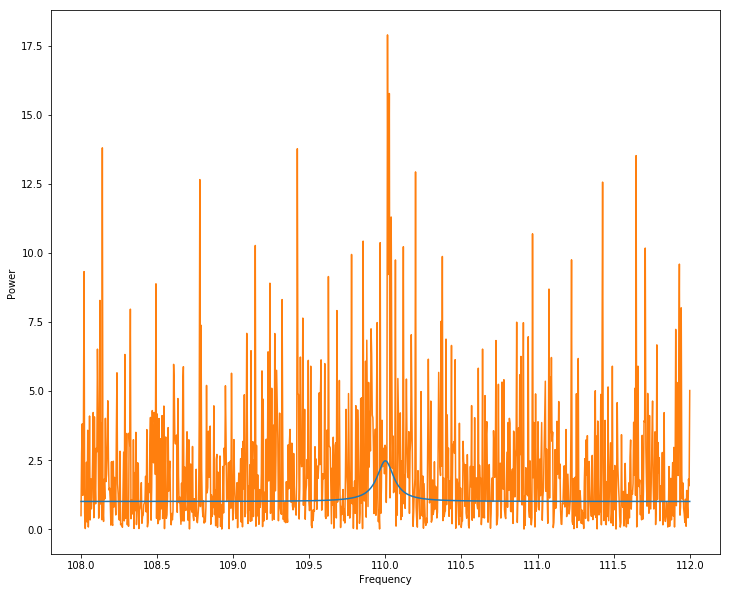

In [98]:
npts = 1000
f = np.linspace(108,112,npts)
b = 0.0
h = -5.0
w = -2.0
nu = 110.0
model = np.exp(b) + (np.exp(h)/((nu - f)**2 + (np.exp(w))**2/4))
data = model * np.random.chisquare(2, npts)
fig, ax = plt.subplots()
ax.plot(f, model, zorder=5)
ax.plot(f, data)
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')

So Let's build a STAN model that tries to deal with this.

In [96]:
mode_code = '''
data {
    int<lower = 0> N;
    vector[N] f;
    vector[N] p;
}
parameters {
    real<lower=108.0, upper=112.0> nu;
    real<lower = -3, upper = 1> w;
    real<lower = -2, upper = 8> h;
    real<lower = -4, upper = 8> b;
}
model {
    vector[N] tmp;
    for (i in 1:N)
        tmp[i] = exp(b) + exp(h) / (pow(nu - f[i], 2) + (exp(w)^2/4)); 
    p ~ gamma(1, 2.0 * tmp);
    nu ~ normal(110.0, 0.3);
}
'''
sm = pystan.StanModel(model_code=mode_code, model_name='Modefit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Modefit_ac3e48789478dcbe6e7c048627e89cf5 NOW.


/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


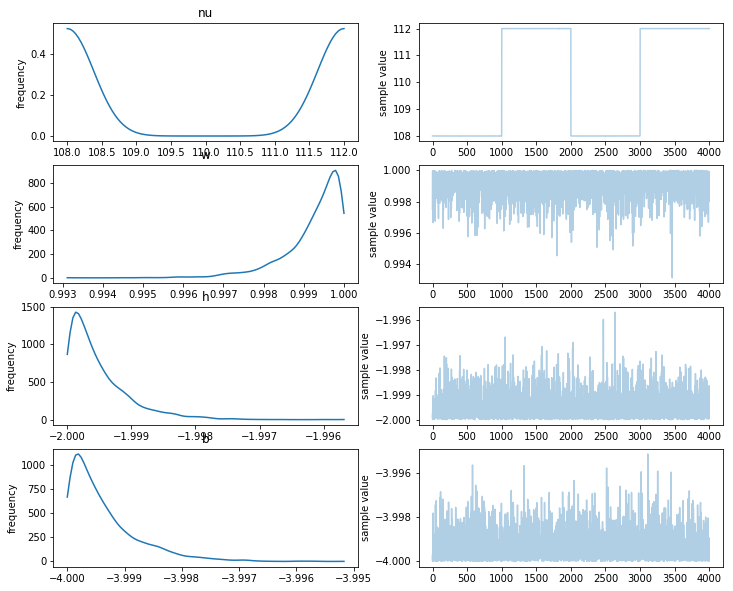

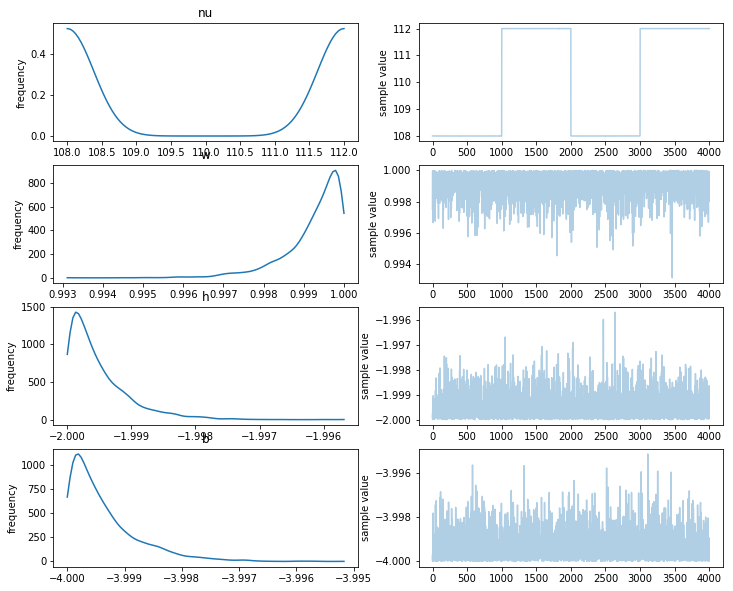

In [97]:
dat = {'N': len(f),
      'f': f,
      'p': data}
fit = sm.sampling(data=dat, iter=2000, chains=4)
fit.plot()

In [91]:
print(fit)

Inference for Stan model: Modefit_b207cdbfd218882b2426d14fad49e98e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
nu   109.99  8.1e-3    0.3  109.4 109.79  110.0  110.2 110.59   1393    1.0
w      4.97    0.02   0.72    3.4   4.46   5.09   5.57   5.95   1059    1.0
h      0.23    0.06   1.57  -1.92   -1.1-4.0e-3   1.33   3.57    600    1.0
b      -3.9  2.1e-3   0.04  -3.98  -3.93   -3.9  -3.87  -3.82    385    1.0
lp__  -4183    0.06    1.6  -4188  -4184  -4183  -4182  -4181    691   1.01

Samples were drawn using NUTS at Wed Feb 14 21:09:00 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


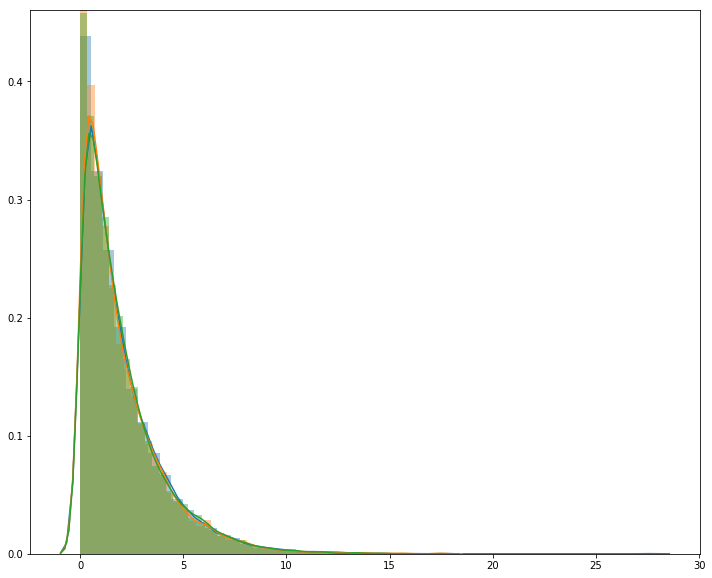

In [94]:
npts = 10000
sns.distplot(np.random.chisquare(2, npts))
sns.distplot(np.random.gamma(1.0, 2.0, npts))
sns.distplot(np.random.exponential(2.0, npts))